In [1]:
import copy

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error,r2_score, mean_squared_error, mean_absolute_error, accuracy_score

In [2]:
data = pd.read_csv('data.csv')

In [3]:
print(f'{data.shape[0]} записів і {data.shape[1]} метрики в наявних даних.')

1467832 записів і 63 метрики в наявних даних.


In [4]:
data.head()

,total_sessions_day0,total_sessions_day1,total_sessions_day3,total_sessions_day7,chapters_finished_day0,chapters_finished_day1,chapters_finished_day3,chapters_finished_day7,chapters_opened_day0,chapters_opened_day1,...,install_date,country_code,ad_ltv_day0,ad_ltv_day1,ad_ltv_day3,platform,target_sub_ltv_day30,target_iap_ltv_day30,target_ad_ltv_day30,target_full_ltv_day30
0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_135,0.0,0.0,0.0,ios,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.0,0.0,0.0,android,0.0,0.0,0.0,0.0
2,1.0,2.0,2.0,2.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.0,0.0,0.0,android,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.0,0.0,0.0,ios,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_203,0.0,0.0,0.0,android,0.0,0.0,0.0,0.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1467832 entries, 0 to 1467831
Data columns (total 63 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   total_sessions_day0         1466467 non-null  float64
 1   total_sessions_day1         1466465 non-null  float64
 2   total_sessions_day3         1466464 non-null  float64
 3   total_sessions_day7         1466458 non-null  float64
 4   chapters_finished_day0      1467832 non-null  int64  
 5   chapters_finished_day1      1467832 non-null  int64  
 6   chapters_finished_day3      1467832 non-null  int64  
 7   chapters_finished_day7      1467832 non-null  int64  
 8   chapters_opened_day0        1467832 non-null  int64  
 9   chapters_opened_day1        1467832 non-null  int64  
 10  chapters_opened_day3        1467832 non-null  int64  
 11  chapters_opened_day7        1467832 non-null  int64  
 12  chapters_closed_day0        1467832 non-null  int64  
 1

In [6]:
data.isna().sum()

total_sessions_day0       1365
total_sessions_day1       1367
total_sessions_day3       1368
total_sessions_day7       1374
chapters_finished_day0       0
                          ... 
platform                     0
target_sub_ltv_day30         0
target_iap_ltv_day30         0
target_ad_ltv_day30          0
target_full_ltv_day30        0
Length: 63, dtype: int64

Кількість спотворених даних відносно розміру вибірки мізерна то ж можна позбутися цих даних без втрати спеціфічності даних

In [7]:
data = data.dropna()

Перевіримо наявність дублікатів так як вибірка велика

In [8]:
data.duplicated().sum()

839876

Значна кількість дублікатів може вказувати на ненормальний розподіл даних

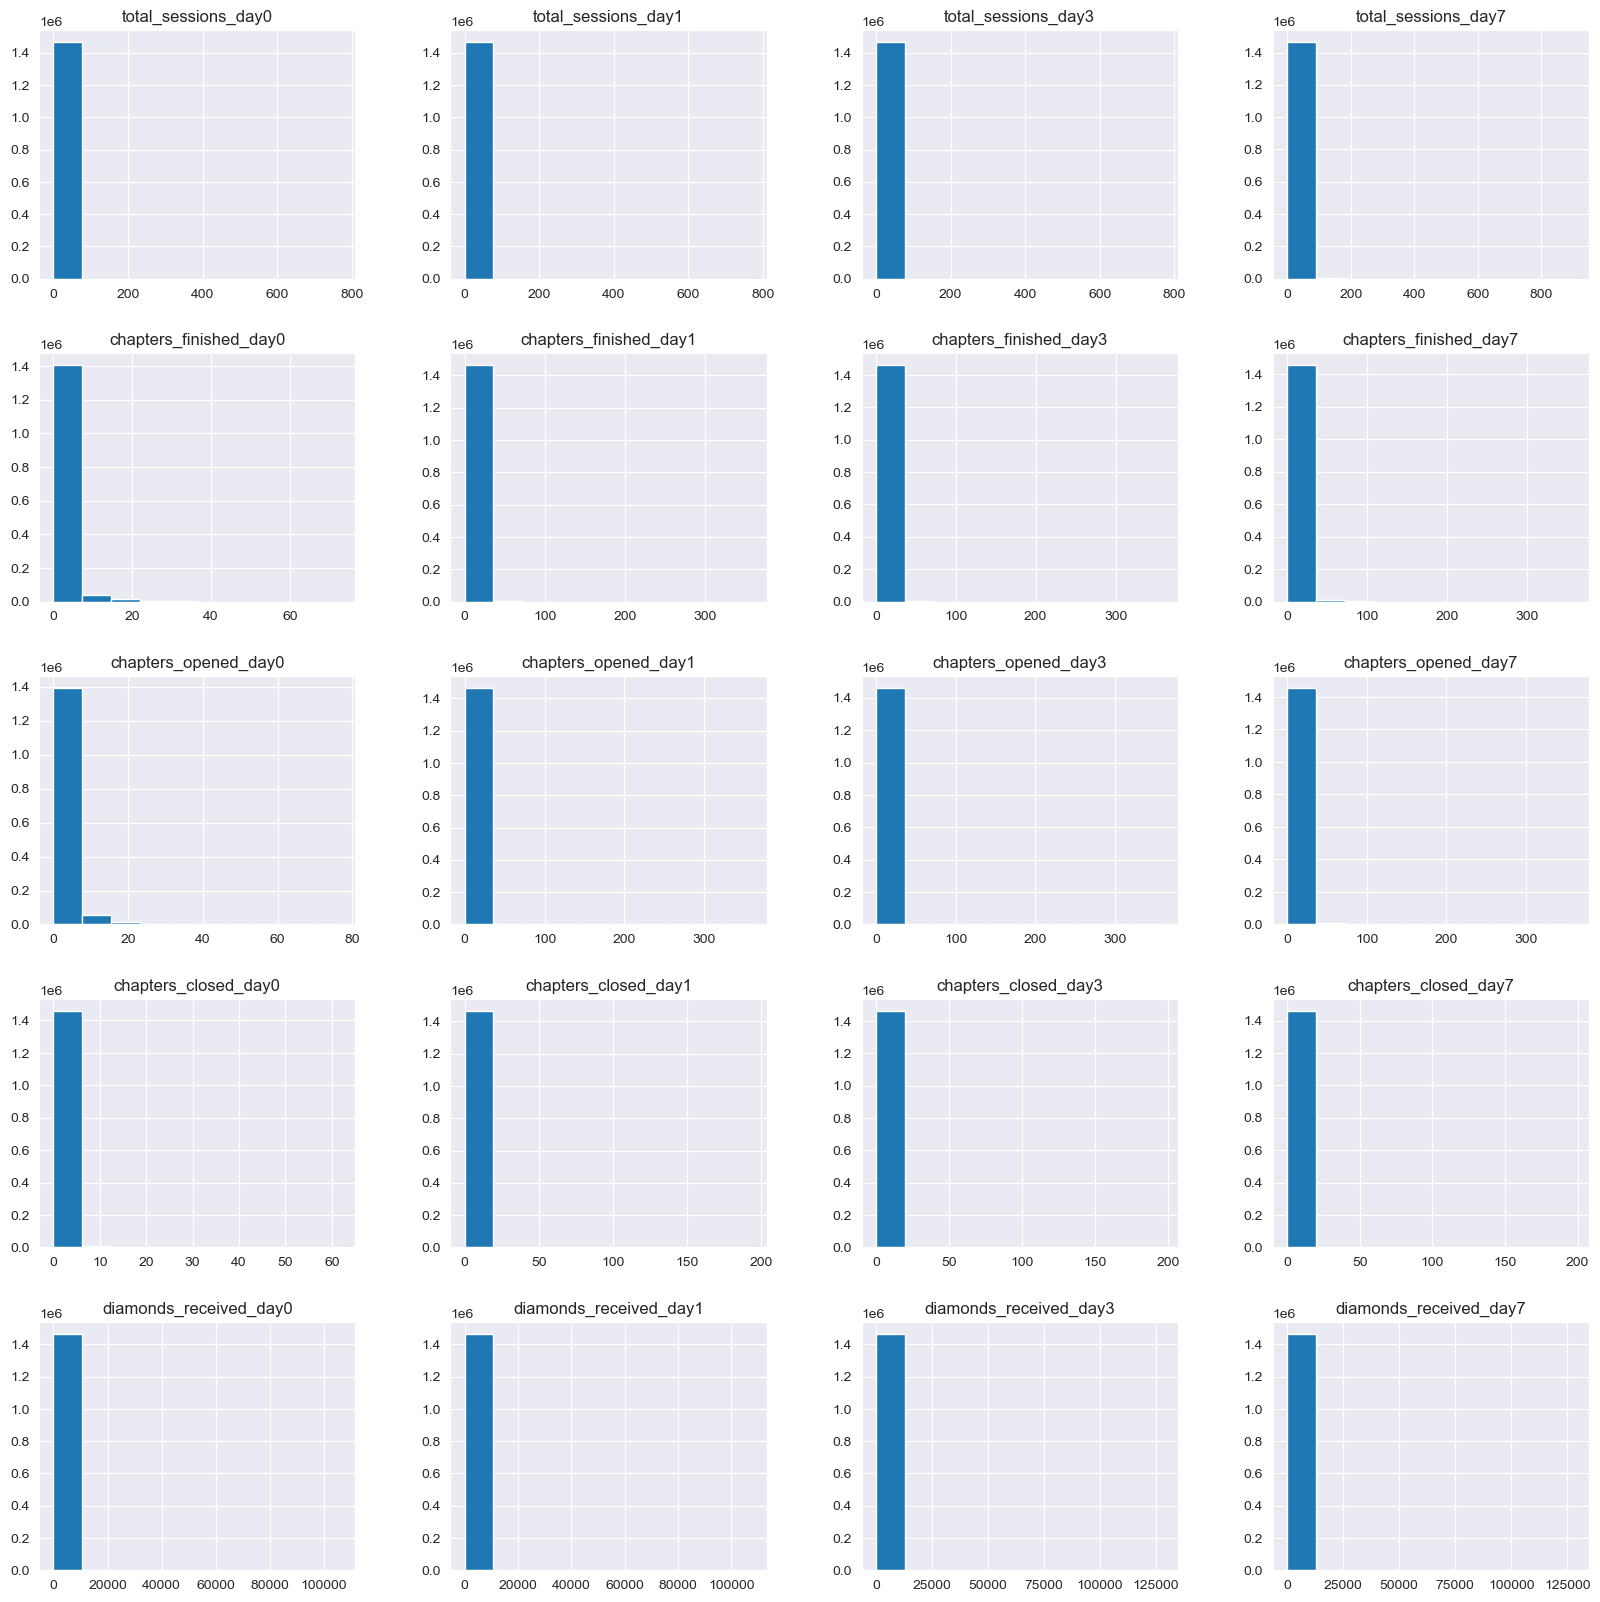

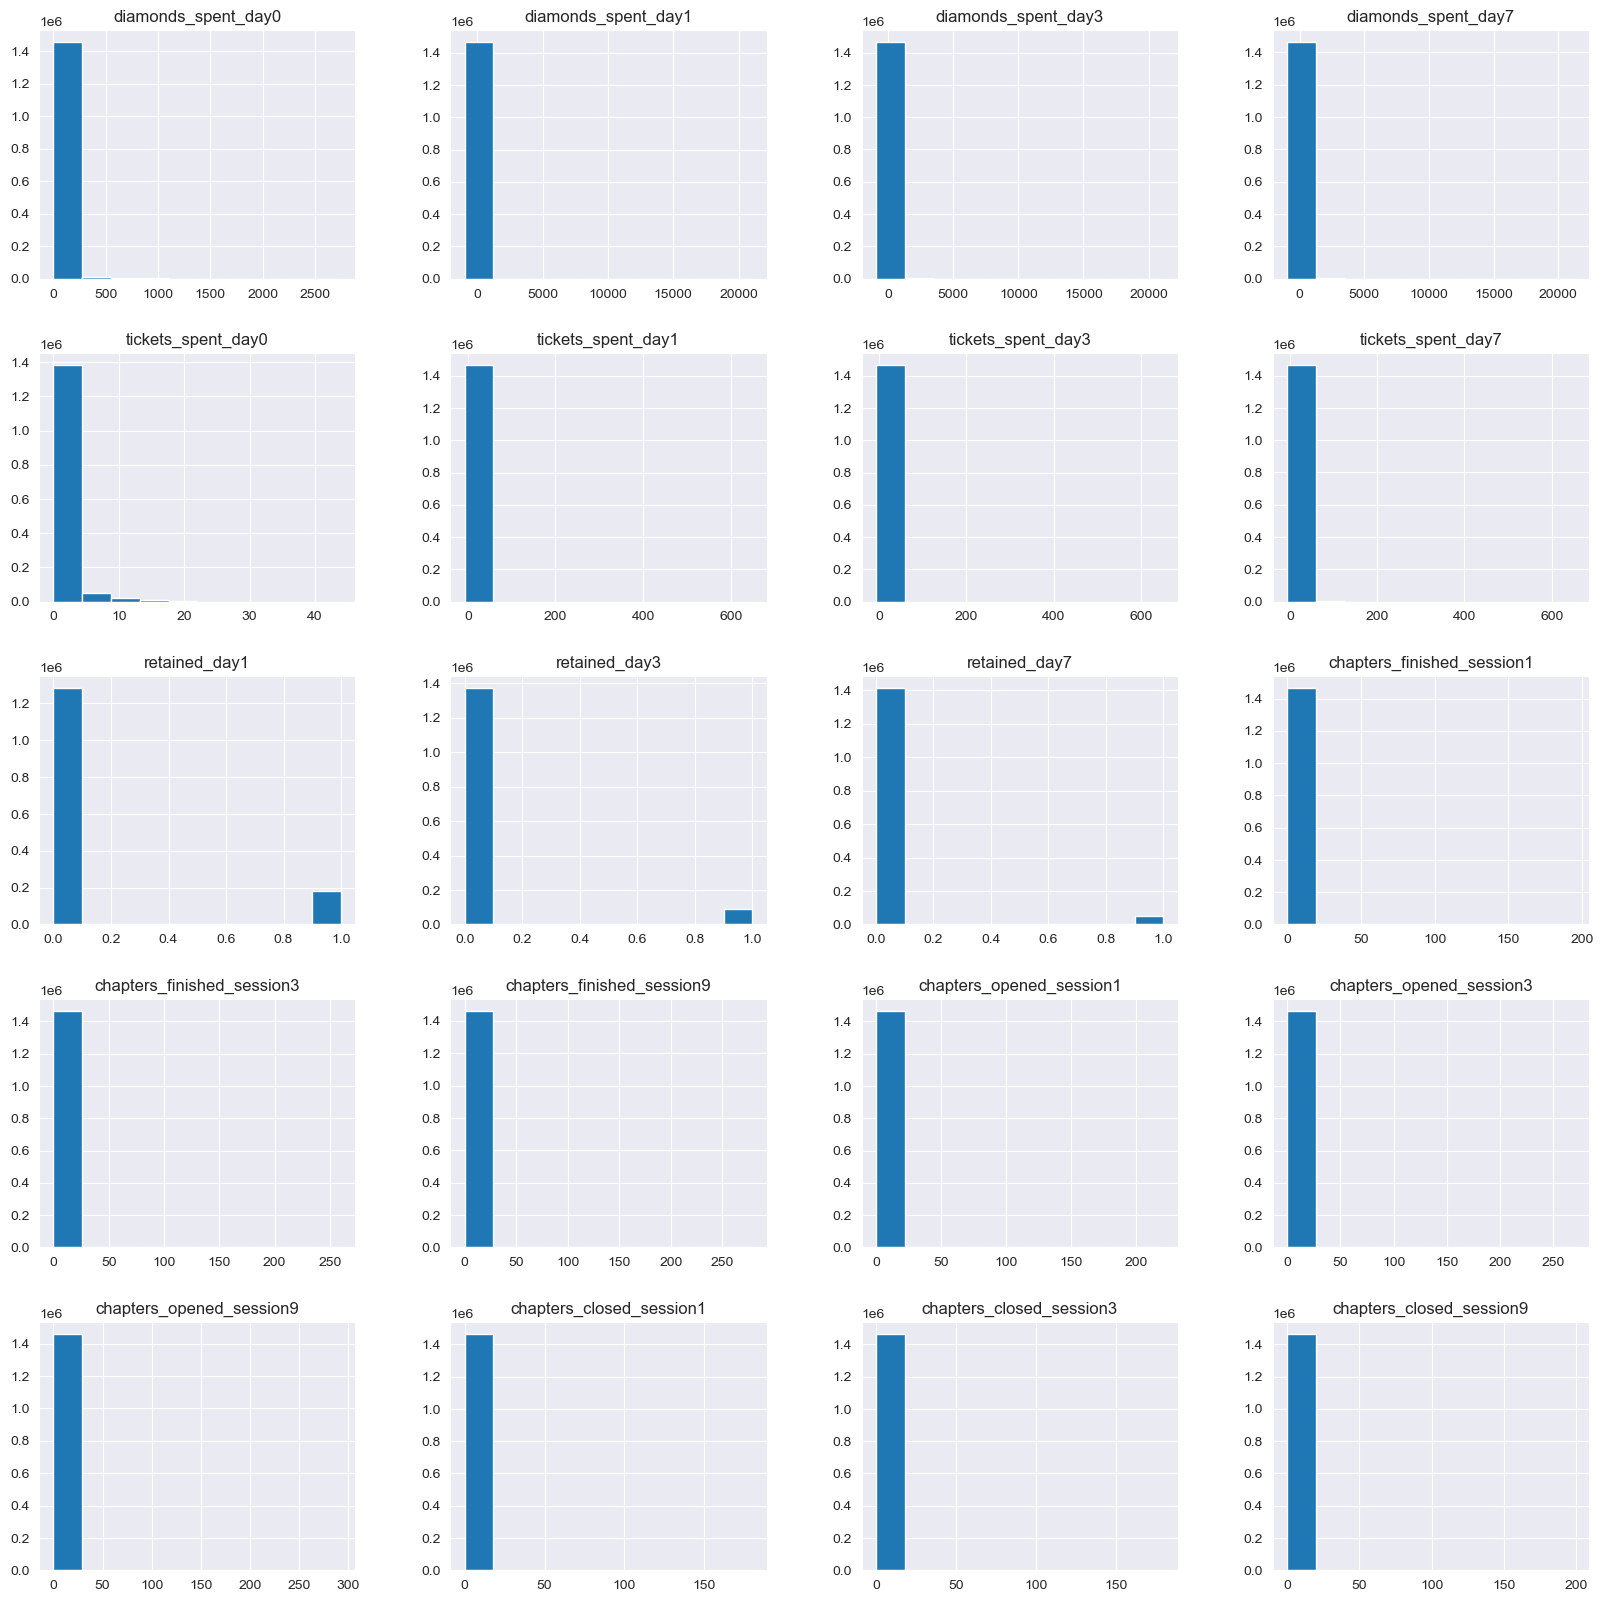

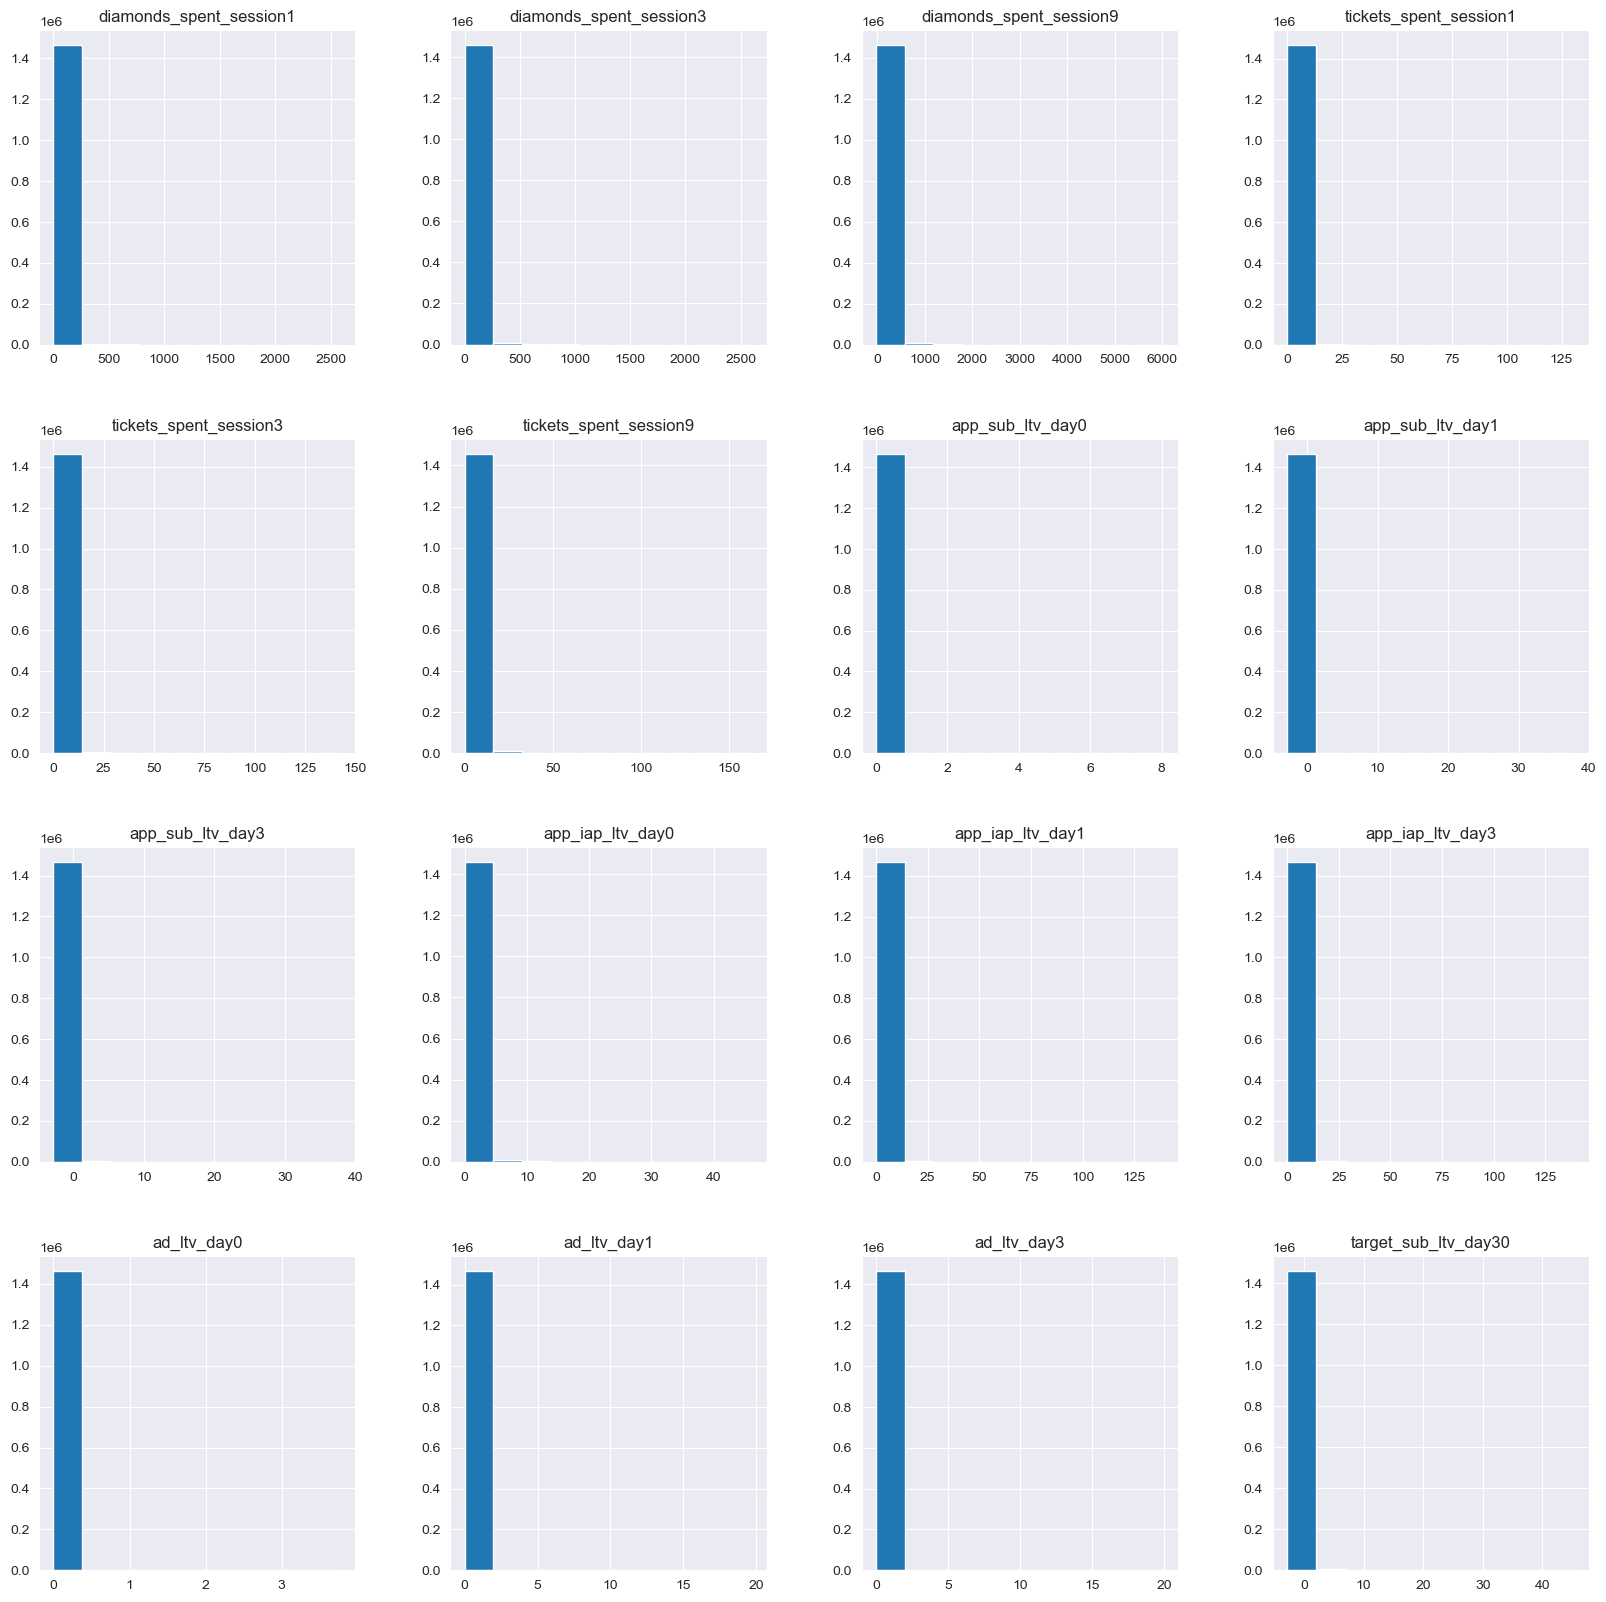

In [9]:
for i in [20, 40, 60]:
    data[data.columns[i-20:i]].hist(figsize= (20,20))
plt.show()

Дійсно, всі наявні метрики мають дуже сильний нахил праворуч
Перевіримо чи видалення дублікатів вплине на розподіл

In [10]:
data = data.drop_duplicates()

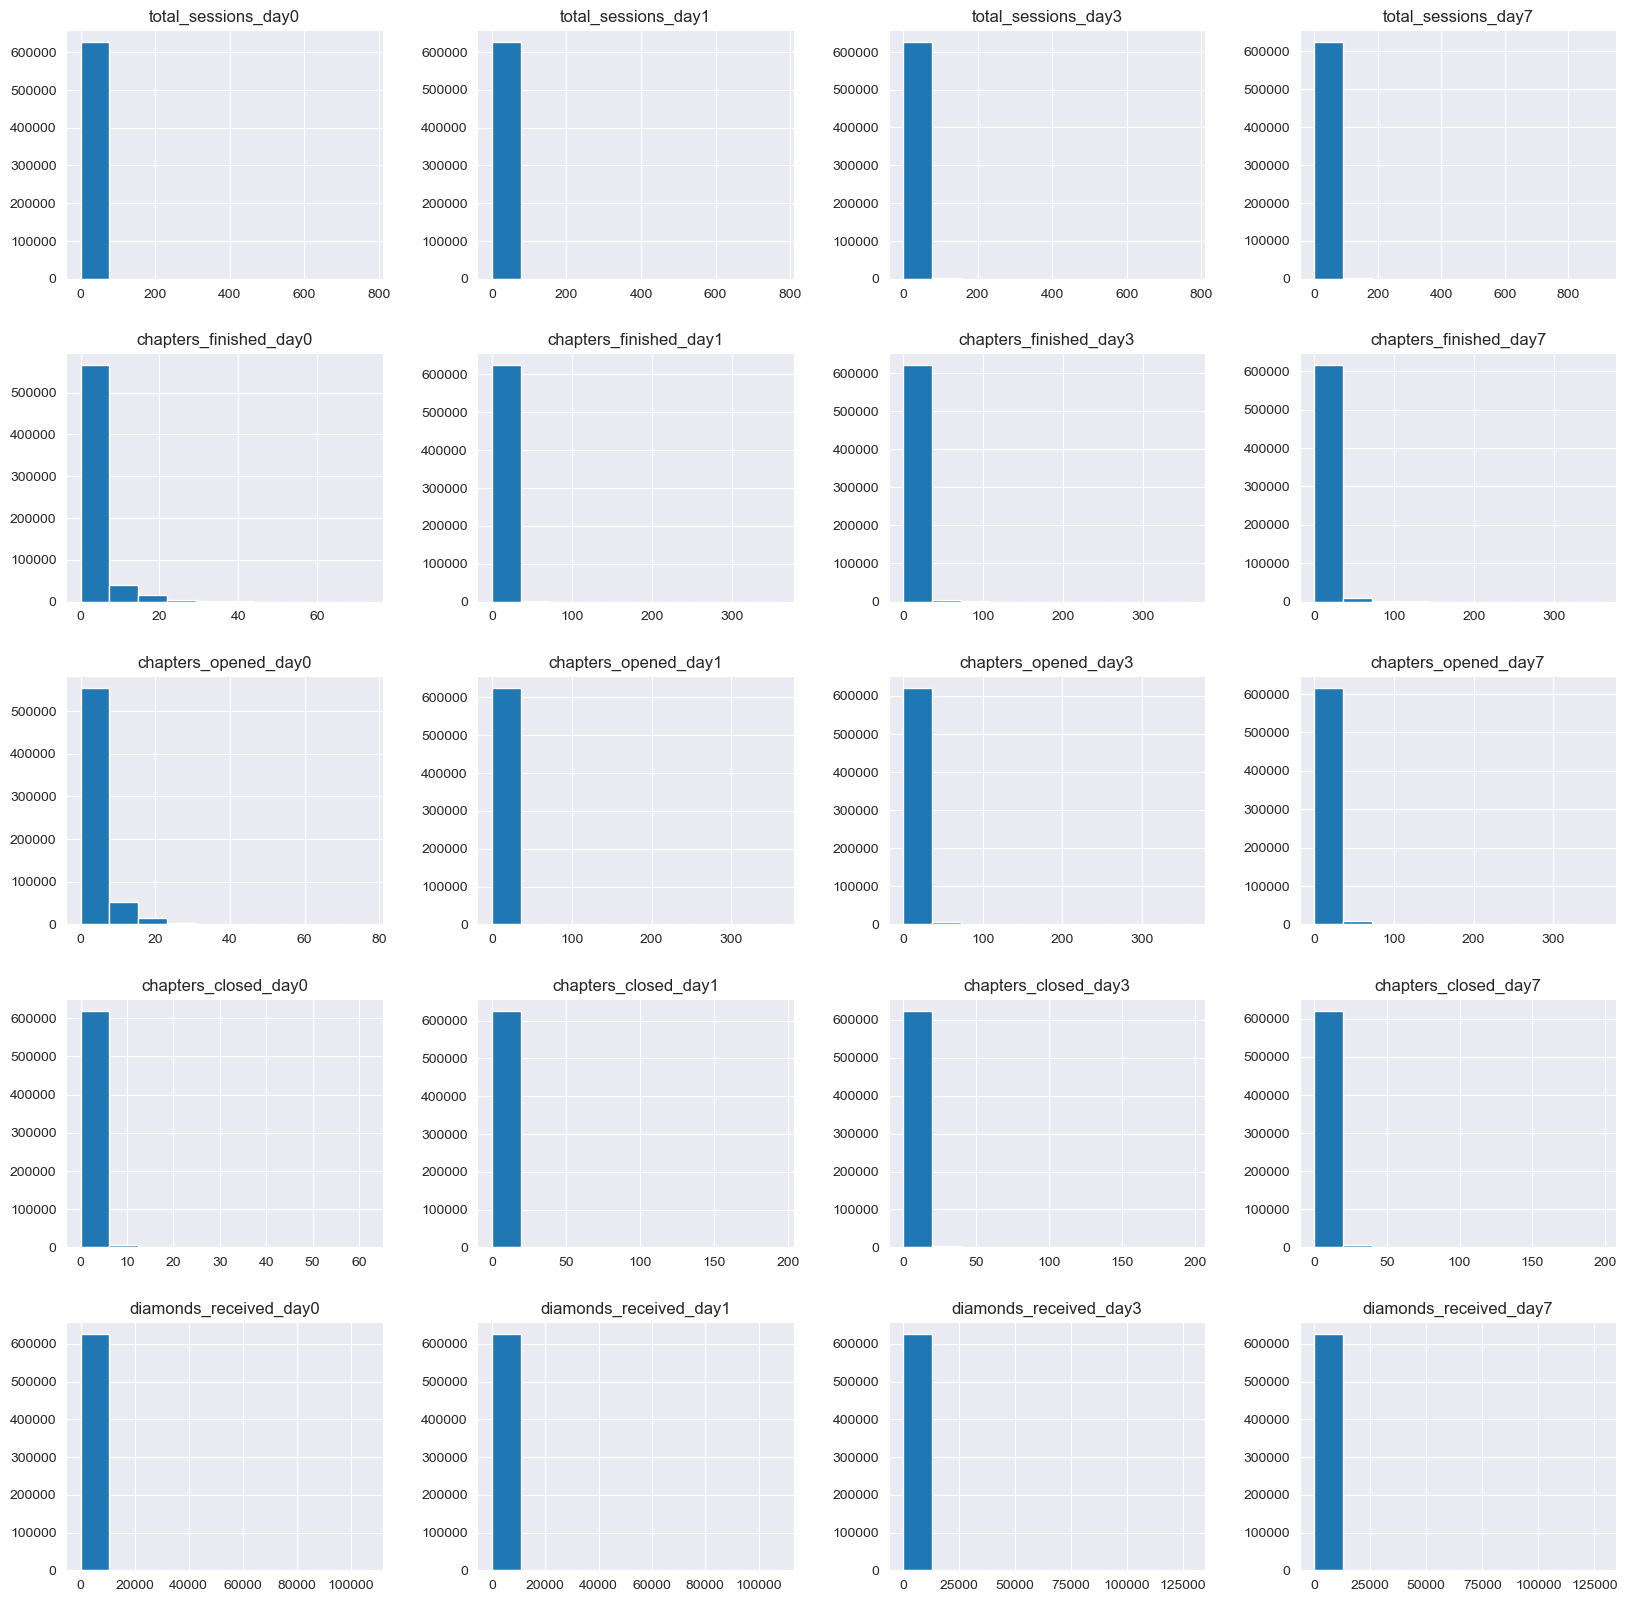

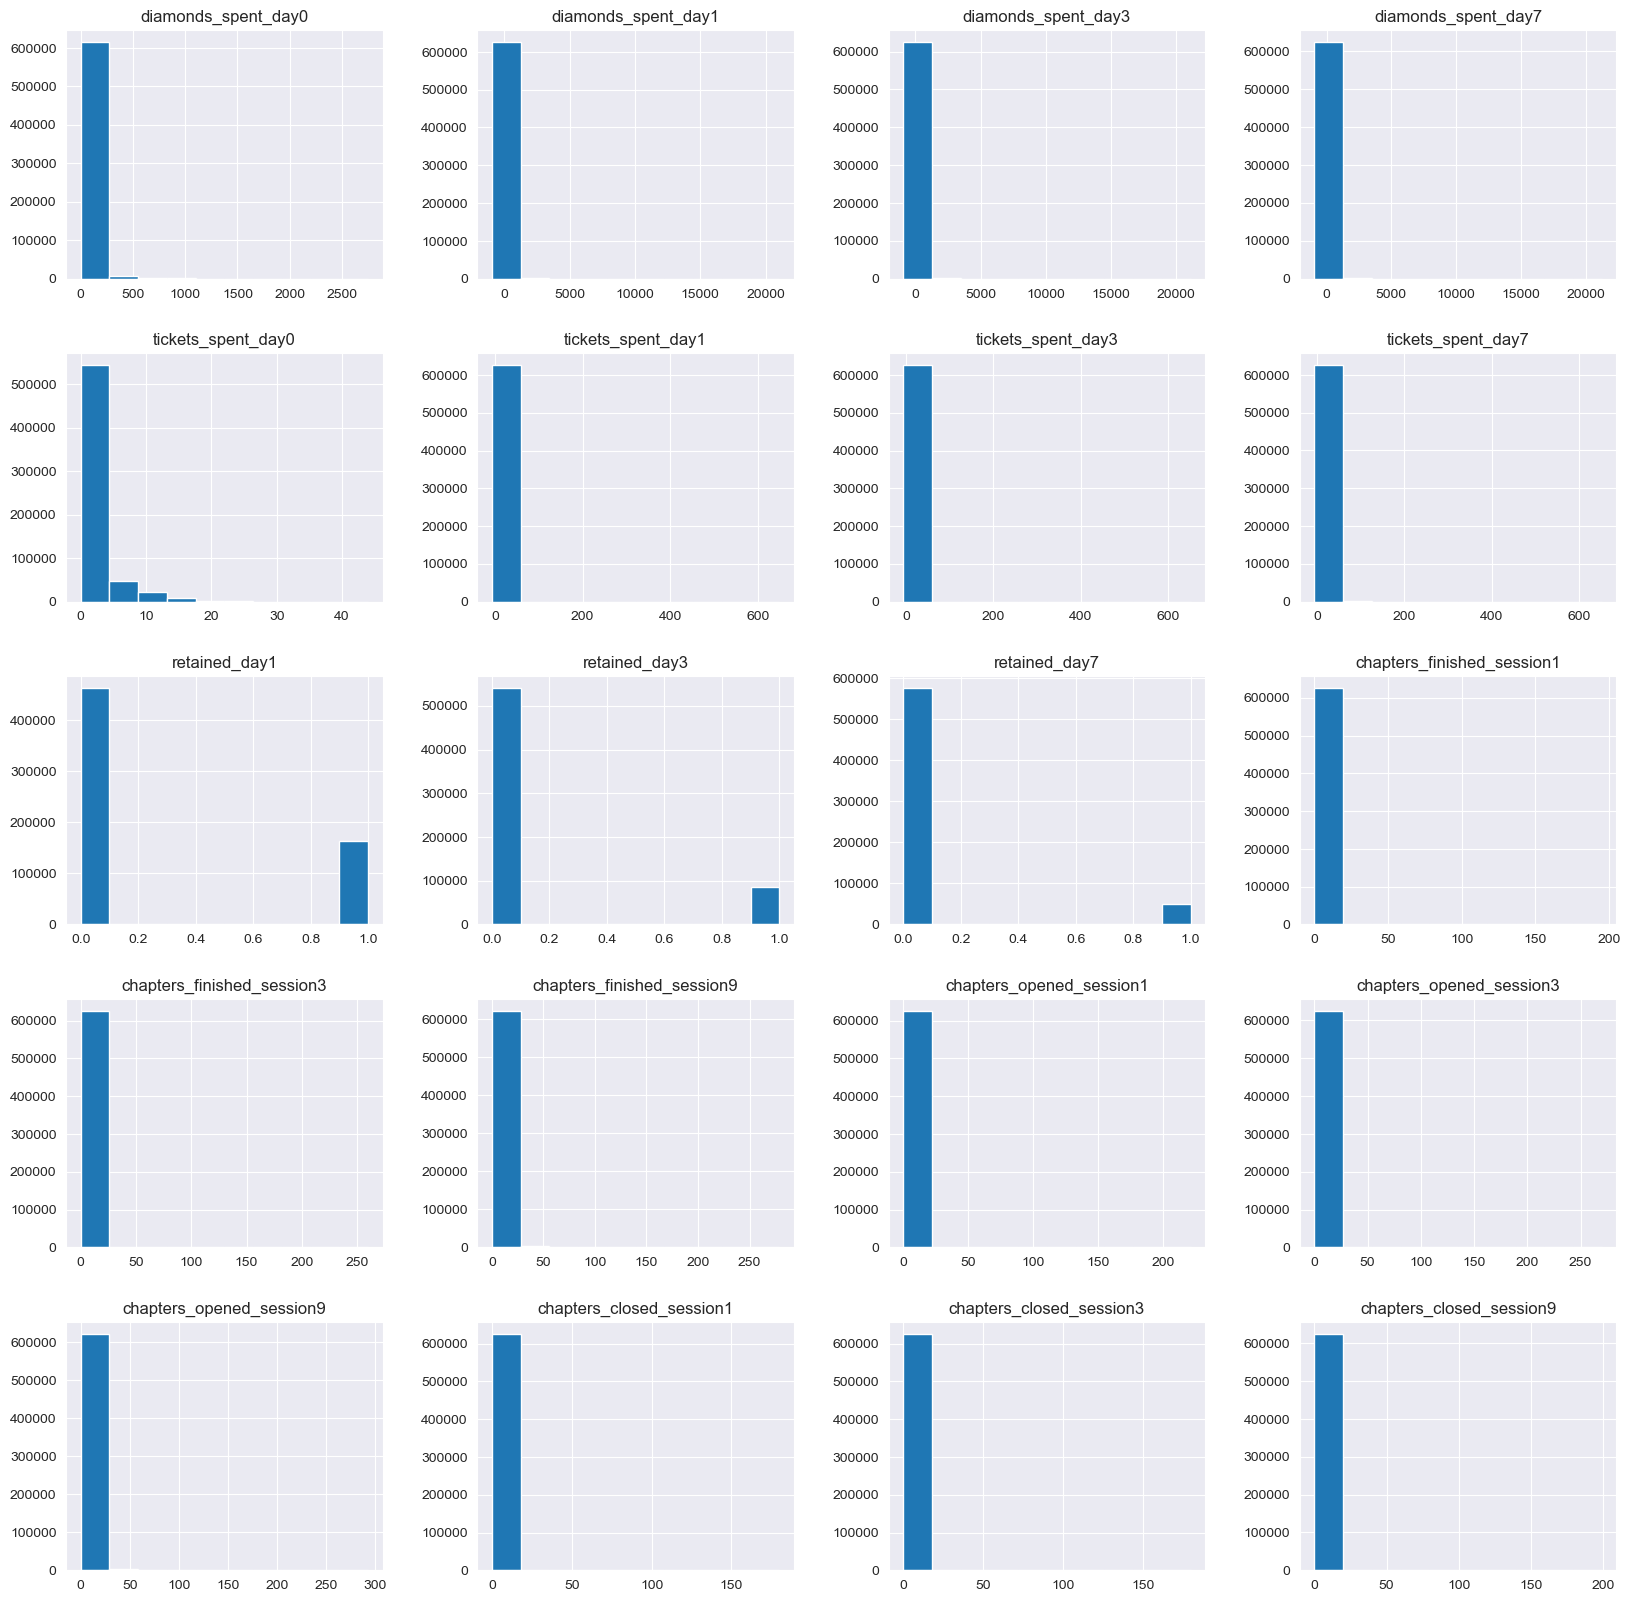

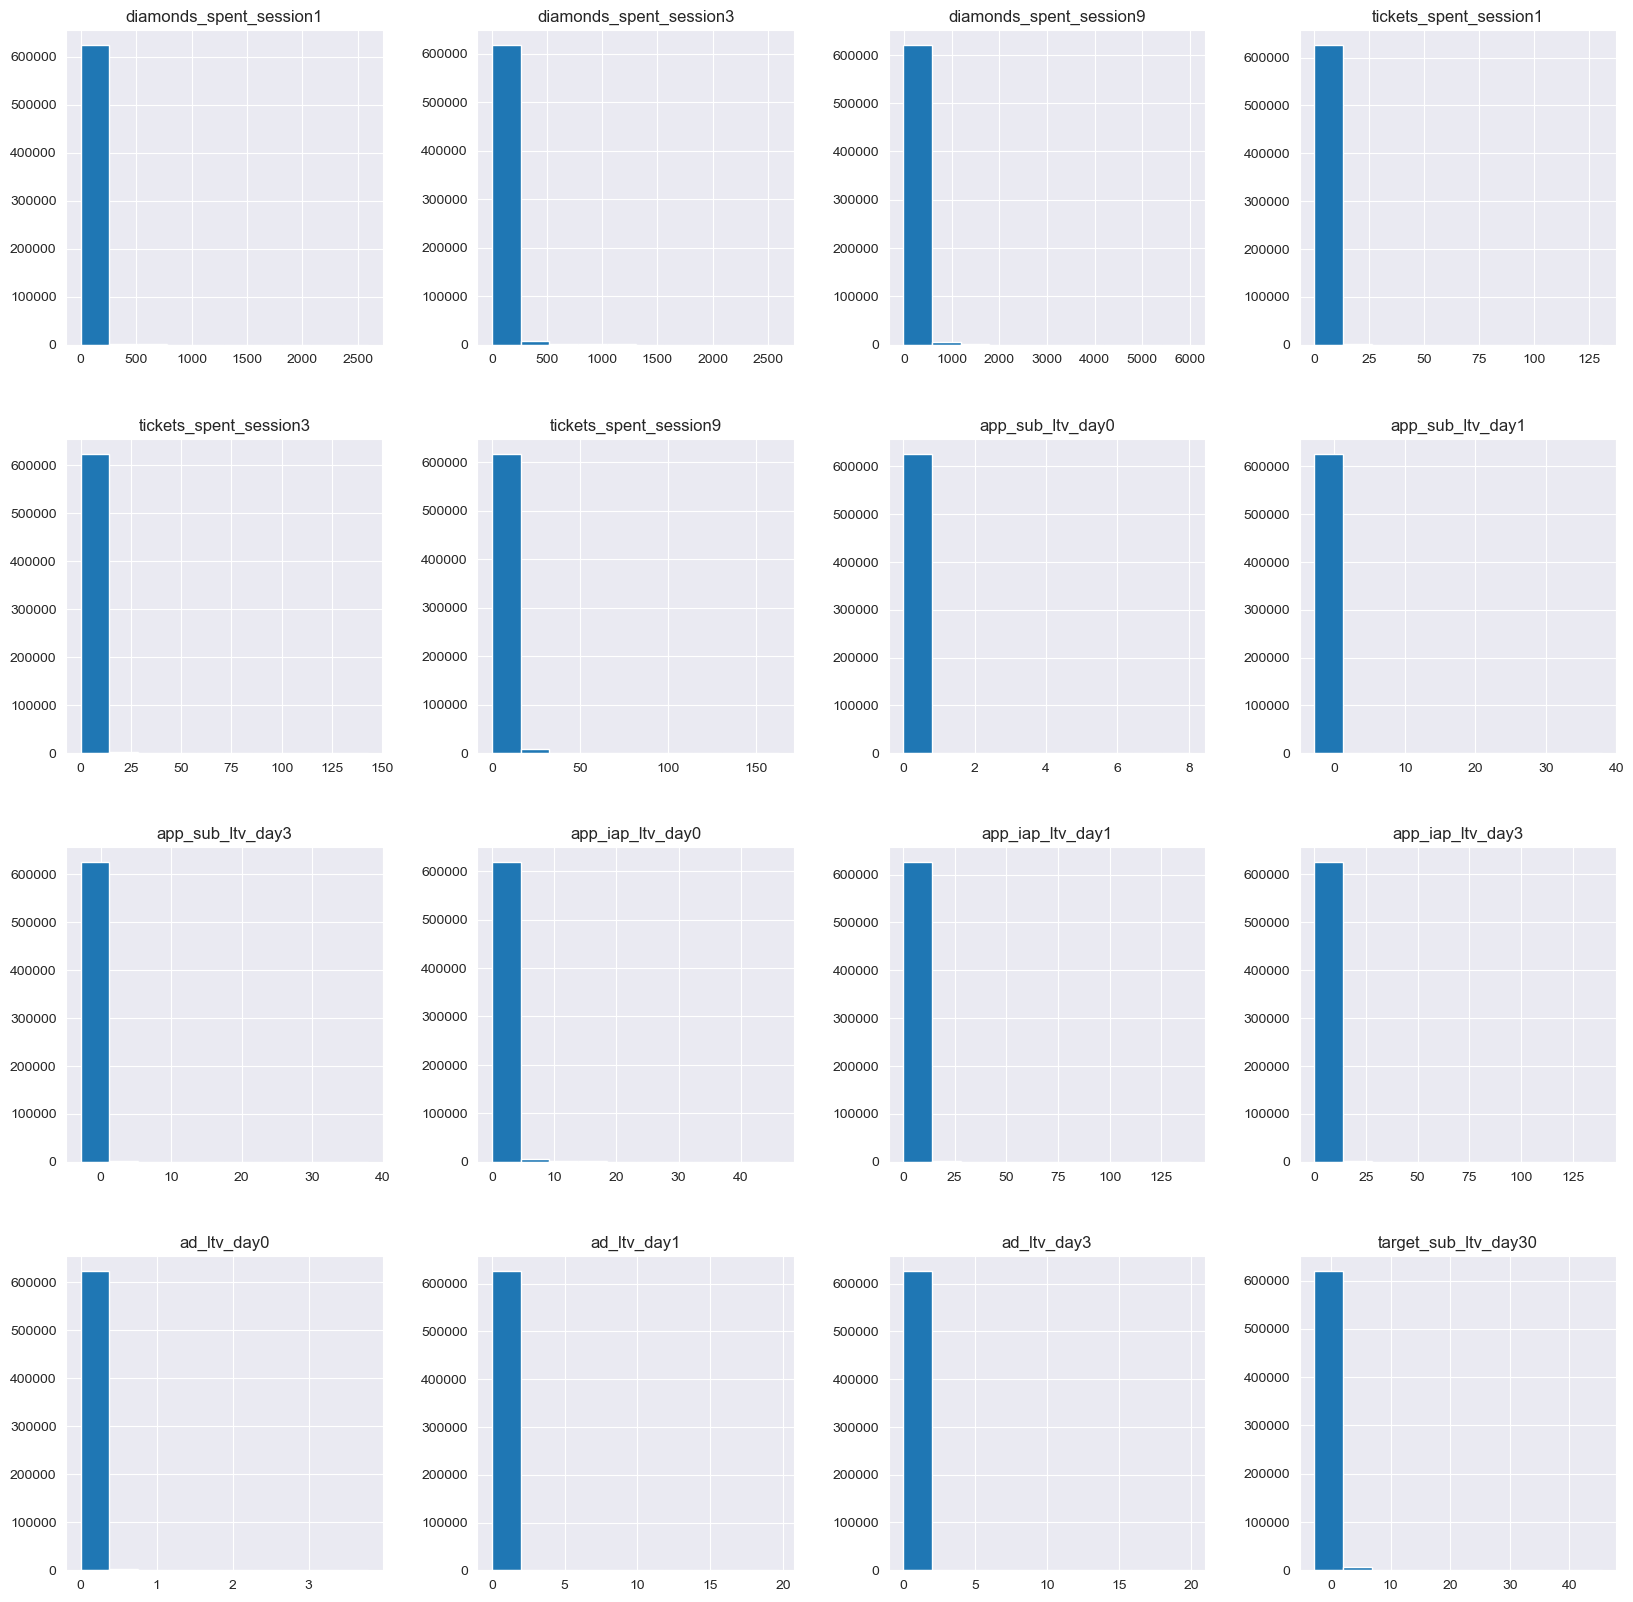

In [11]:
for i in [20, 40, 60]:
    data[data.columns[i-20:i]].hist(figsize= (20,20))
plt.show()

Розподіл даних не змінюється суттєво, тож можна прибрати дублікати для зменшення часу тренування моделі Перевіримо кількість викидів у метриках

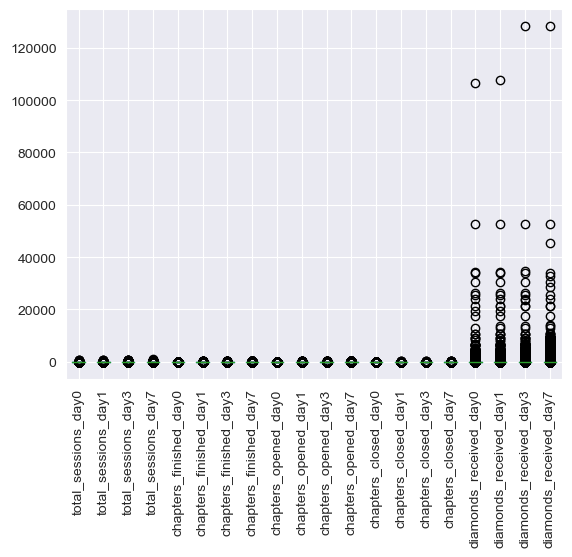

In [12]:
data[data.columns[:20]].boxplot(rot = 90)
plt.show()

Наявні колонки з викидами

Виходячі з того що вимагається гарно інтерпретована модель для задачі регресії, то вибір звужується до моделей, що базовані на деревах, моделі методу опорних векторів і звичайної лінійної регресії.

Метод опорних векторів і лінійна регресія не зможуть коректно відпрацювати на такій великій виборці, а базовані на деревах модеелі як раз добре впораються з монотонно розподіленими даними і викидами.

Внаслідок вибору моделі зникає потреба в суттєвій трансформації даних перед тренуванням моделі. Обробимо категоріальні метрики і перейдемо до вибору моделі, що базується на деревах.

In [13]:
data.select_dtypes(include ='object')

,media_source,install_date,country_code,platform
0,SOURCE_23,2021-12-03,COUNTRY_135,ios
1,SOURCE_2,2021-12-03,COUNTRY_141,android
2,SOURCE_17,2021-12-03,COUNTRY_141,android
3,SOURCE_23,2021-12-03,COUNTRY_141,ios
4,SOURCE_1,2021-12-03,COUNTRY_203,android
...,...,...,...,...
1467827,SOURCE_17,2021-12-30,COUNTRY_141,ios
1467828,SOURCE_23,2021-12-30,COUNTRY_141,ios
1467829,SOURCE_23,2021-12-30,COUNTRY_141,ios
1467830,SOURCE_4,2021-12-30,COUNTRY_141,ios


In [14]:
data = pd.get_dummies(data, columns = ['platform'],prefix = 'is_', drop_first=True)

In [15]:
data['country_code'].value_counts()

COUNTRY_141    209810
COUNTRY_155     78238
COUNTRY_13      63288
COUNTRY_108     28278
COUNTRY_72      27509
                ...  
COUNTRY_73          1
COUNTRY_10          1
COUNTRY_151         1
COUNTRY_175         1
COUNTRY_37          1
Name: country_code, Length: 224, dtype: int64

In [16]:
data['media_source'].value_counts()

SOURCE_4     188812
SOURCE_17    182896
SOURCE_23    145679
SOURCE_2      36671
SOURCE_1      15006
SOURCE_10     14161
SOURCE_12     11021
SOURCE_6       9471
SOURCE_19      6174
SOURCE_5       5624
SOURCE_18      3006
SOURCE_16      2984
SOURCE_9       2651
SOURCE_14      1439
SOURCE_7        590
SOURCE_3        193
SOURCE_15        73
SOURCE_8         46
SOURCE_11        24
SOURCE_22        23
SOURCE_21        21
SOURCE_0         13
SOURCE_20         2
SOURCE_13         2
Name: media_source, dtype: int64

Судячи з кількості зустрічаємих значень, можна зробити висновок, що в странах і ресурсах, що частіше зустрічаються кореляція більше, і можна зменшити значну кілкість метрик до найпопулярніших країн та ресурсів шляхом розділеня країн на основні популярні і непопулярні.

In [17]:
for source in data['media_source'].value_counts().index.to_list():
    print('Correlation for ', source, ' :', (data['media_source'] == source).astype(int).corr(data['target_full_ltv_day30']))

Correlation for  SOURCE_4  : -0.05533935048931173
Correlation for  SOURCE_17  : 0.06917636537205502
Correlation for  SOURCE_23  : 0.0007729390651612516
Correlation for  SOURCE_2  : -0.025455662608711533
Correlation for  SOURCE_1  : 0.0070255504088134945
Correlation for  SOURCE_10  : -0.00019448755841678975
Correlation for  SOURCE_12  : -0.018611383727907643
Correlation for  SOURCE_6  : 0.002664231728869805
Correlation for  SOURCE_19  : -0.007698650043010851
Correlation for  SOURCE_5  : 0.017770136256414274
Correlation for  SOURCE_18  : 0.0032406623045737708
Correlation for  SOURCE_16  : 0.0006513297842895053
Correlation for  SOURCE_9  : -0.00776681855145323
Correlation for  SOURCE_14  : 0.0018073424536373204
Correlation for  SOURCE_7  : -0.0028213730487137
Correlation for  SOURCE_3  : 0.0010689944718224658
Correlation for  SOURCE_15  : -0.0018787261434893524
Correlation for  SOURCE_8  : 1.8728226720221733e-05
Correlation for  SOURCE_11  : -0.0006967035515181019
Correlation for  SOURCE_

Судячи з даних вище, залежність вихідної метрики від медіа ресурсу знижується, якщо цей ресурс непопулярний

In [18]:
for country in data['country_code'].value_counts().index.to_list():
    print('Correlation for ', country, ' :', (data['country_code'] == country).astype(int).corr(data['target_full_ltv_day30']))

Correlation for  COUNTRY_141  : 0.10670898472292606
Correlation for  COUNTRY_155  : 0.02570041023298699
Correlation for  COUNTRY_13  : -0.05489524079230851
Correlation for  COUNTRY_108  : -0.03643434163871716
Correlation for  COUNTRY_72  : 0.011475900029762752
Correlation for  COUNTRY_35  : -0.03199159134834246
Correlation for  COUNTRY_38  : 0.014997040822990639
Correlation for  COUNTRY_137  : -0.034497789660571564
Correlation for  COUNTRY_208  : -0.022707843954919125
Correlation for  COUNTRY_203  : -0.01596838780443535
Correlation for  COUNTRY_156  : -0.010747420736800456
Correlation for  COUNTRY_52  : -0.015247974773776325
Correlation for  COUNTRY_23  : -0.007837425160657161
Correlation for  COUNTRY_8  : -0.009791737532693015
Correlation for  COUNTRY_129  : -0.00112317683363097
Correlation for  COUNTRY_189  : -0.014905535207796545
Correlation for  COUNTRY_204  : 0.001978750659169179
Correlation for  COUNTRY_26  : -0.002443586802015109
Correlation for  COUNTRY_218  : -0.01371591436517

Результати ідентичні до медіа ресурсів. Залишимо 10 найважливіших ресурсів і 25 найпопулярніших країн користування, тим самим значно зменшимо кількість категоріальних колонок, незначно втрачаючи інформацію.

In [19]:
data['not_common_source'] = True
data['not_common_country'] = True

for source in data['media_source'].value_counts()[:10].index.to_list(): ## Відбір популярних сорсов
    data[source] = (data['media_source'] == source).astype(int)
    data['not_common_source'] = np.logical_and((data['media_source'] != source), data['not_common_source'])

for country in data['country_code'].value_counts()[:25].index.to_list():## Відбір популярних країн
    data[country] = (data['country_code'] == country).astype(int)
    data['not_common_country'] = np.logical_and((data['country_code'] != country), data['not_common_country'])

In [20]:
X = data.drop(['install_date', 'media_source', 'country_code','target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30', 'target_full_ltv_day30'], axis = 1)
y = data['target_full_ltv_day30']

Враховуючи розмір вибірки розподілимо дані на тренувальні і тестові у відношенні 99:1

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=68)

Організатори пропонують використати метрики МАРЕ МАЕ і RMSE. Враховуючи вимогу до робастності і спецефічність даних, обираємо МАЕ як стійку до викідів і легкою до інтерпретації. Оберемо між моделями випадкового лісу та бустінгу спираючись на ці метрики.

In [22]:
rfr = RandomForestRegressor(n_estimators= 30, n_jobs= -1)

rfr.fit(X_train, y_train)
prediction_train = rfr.predict(X_train)
prediction_test = rfr.predict(X_test)
print('RMSE on train :', mean_squared_error(y_train, prediction_train, squared=False))
print('RMSE on test :', mean_squared_error(y_test, prediction_test, squared=False))
print('-'*20)
print('MAPE on train :', mean_absolute_percentage_error(y_train, prediction_train))
print('MAPE on test :', mean_absolute_percentage_error(y_test, prediction_test))
print('-'*20)
print('MAE on train :', mean_absolute_error(y_train, prediction_train))
print('MAE on test :', mean_absolute_error(y_test, prediction_test))
print('-'*20)
print('R2 on train :', r2_score(y_train, prediction_train))
print('R2 on test :', r2_score(y_test, prediction_test))

RMSE on train : 0.5841173961138081
RMSE on test : 1.3556657478915017
--------------------
MAPE on train : 7494588839709.09
MAPE on test : 19567456987504.906
--------------------
MAE on train : 0.06770482491720071
MAE on test : 0.18817151097197932
--------------------
R2 on train : 0.9713484592424593
R2 on test : 0.8489614961059482


In [23]:
xgr = xgb.XGBRegressor(n_estimators = 30, n_jobs = -1)

xgr.fit(X_train, y_train)
prediction_train = xgr.predict(X_train)
prediction_test = xgr.predict(X_test)
print('RMSE on train :', mean_squared_error(y_train, prediction_train, squared=False))
print('RMSE on test :', mean_squared_error(y_test, prediction_test, squared=False))
print('-'*20)
print('MAPE on train :', mean_absolute_percentage_error(y_train, prediction_train))
print('MAPE on test :', mean_absolute_percentage_error(y_test, prediction_test))
print('-'*20)
print('MAE on train :', mean_absolute_error(y_train, prediction_train))
print('MAE on test :', mean_absolute_error(y_test, prediction_test))
print('-'*20)
print('R2 on train :', r2_score(y_train, prediction_train))
print('R2 on test :', r2_score(y_test, prediction_test))

RMSE on train : 1.0099580573328804
RMSE on test : 1.2557605996436358
--------------------
MAPE on train : 34412524826819.176
MAPE on test : 32631572152254.56
--------------------
MAE on train : 0.16843347789643412
MAE on test : 0.1988782909942099
--------------------
R2 on train : 0.914344673090515
R2 on test : 0.8704026462739256


З результатів можна зробити висновок, що більш ефективним для поставленої задачі буде модель градієнтного бустингу, яка і буде обрана як основна.

При тестуванні моделей ми орієнтувалися на MAE, але нажаль, із потрібних нам метрик в objectives xgboost має лише reg:squarederror.

In [24]:
class Model:
    def __init__(self, to_drop=None, target=None):
        """
        :param to_drop: python array with columns to drop
        :param target: python array with target columns
        """
        self.model = MultiOutputRegressor(xgb.XGBRegressor())

        if to_drop is None:
            to_drop = ["install_date", "target_full_ltv_day30"]
        if target is None:
            target=["target_ad_ltv_day30", "target_iap_ltv_day30", "target_sub_ltv_day30"]

        self.target = target
        self.to_drop = to_drop
        self.custom_one_hot_media = None
        self.custom_one_hot_country = None

    def split_data(self, data, train_size=0.99, no_duplicates=False, drop_na=True, below_zero=False, random_state=None):
        """
        :param data: df to split
        :param train_size: float, train size in range(0,1)
        :param no_duplicates: bool, to drop duplicates on train, default=False
        :param drop_na: bool, to drop na on train, default=True
        :param below_zero: bool, to leave values below zero on train, default=False
        :param random_state: int, random state of the split, default=None
        :return: python array of split data: [X_train, X_test, y_train, y_test]
        """
        data_copy = copy.deepcopy(data)

        X_train, X_test, y_train, y_test = train_test_split(data_copy.drop(self.target, axis=1), data_copy[self.target], random_state=random_state, train_size=train_size)

        X_train, y_train = self.preprocess_data(X_train, y_train, no_duplicates=no_duplicates, drop_na=drop_na, below_zero=below_zero)
        X_test, y_test = self.preprocess_data(X_test, y_test)

        return [X_train, X_test, y_train, y_test]

    def preprocess_data(self, X, y, no_duplicates=False, drop_na=False, below_zero=True):
        """
        :param X: df, features
        :param y: df, target
        :param no_duplicates: bool, to drop duplicates on train, default=False
        :param drop_na: bool, to drop na on train, default=True
        :param below_zero: bool, to leave values below zero on train, default=False
        :return: processed data
        """
        X.drop(labels=self.to_drop, axis=1, inplace=True)
        X = self.transform(X)

        if no_duplicates:
            indexes = ~X.duplicated()
            X, y = X[indexes], y[indexes]

        if drop_na:
            indexes = ~X.isna().any(axis=1)
            X, y = X[indexes], y[indexes]

        if not below_zero:
            indexes = ~(X<0).any(axis=1)
            X, y = X[indexes], y[indexes]

        return X,y

    def transform(self, data):
        """
        Custom one hot by most common categories.
        :param data: df
        :return: transformed df
        """
        data = copy.copy(data)
        if (self.custom_one_hot_media is None) or (self.custom_one_hot_country is None):
            self.one_hot_init(data)

        data['not_common_source'] = True
        data['not_common_country'] = True

        for source in self.custom_one_hot_media: ## Отбор популярных источников
            if source in data.columns:
                data[source] = (data['media_source'] == source).astype(int)
                data['not_common_source'] = np.logical_and((data['media_source'] != source), data['not_common_source'])

        for country in self.custom_one_hot_country:## Отбор популярных стран скачивания
            if country in data.columns:
                data[country] = (data['country_code'] == country).astype(int)
                data['not_common_country'] = np.logical_and((data['country_code'] != country), data['not_common_country'])

        data = pd.get_dummies(data, columns=['platform'], prefix = 'is_', drop_first = True)

        return data.drop(["media_source", "country_code"], axis=1)

    def one_hot_init(self, X):
        self.custom_one_hot_media = X['media_source'].value_counts()[:10].index.to_list()
        self.custom_one_hot_country = X['country_code'].value_counts()[:25].index.to_list()

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X, one_target=True):
        """
        :param X: df, features
        :param one_target: bool, if False 3 values would be predicted
        :return: df, predicted values
        """
        return (self.model.predict(X)).sum(axis=1) if one_target == True else self.model.predict(X)

    def get_metrics(self, X, y, one_target=True, model_name=None, RMSE=True, MAE=True, MAPE=True, R2=False, MSE=False):
        """
        :param model: ML model, which will predict on X
        :param X: data frame, features
        :param y: data frame, target values
        :param one_target: bool, print metrics for 1 target or for 3
        :param model_name: string, name of the model, if not None name will be printed
        :param RMSE: bool, Root mean square error
        :param MAE: bool, Mean absolute error
        :param MAPE: bool,Mean absolute percentage error
        :param R2: bool, Root 2 error
        :param MSE: bool, Mean square error
        :return: None, prints errors on specified metrics
        """
        metrics = (mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error)
        metric_flags = {"RMSE": RMSE, "MAE": MAE, "MAPE": MAPE, "R2": R2, "MSE": MSE}

        print('-'*20)
        if model_name:
            print(f"Model = {model_name}")
        for metric, m_flag in zip(metrics, metric_flags):
            if metric_flags[m_flag]:
                if m_flag=='RMSE':
                    print(f"{m_flag} on 3 target = {metric(y, self.model.predict(X), squared=False)}" if one_target==False
                          else f"{m_flag} on 1 target = {metric(y.sum(axis=1), self.model.predict(X).sum(axis=1), squared=False)}")
                else:
                    print(f"{m_flag} on 3 target = {metric(y, self.model.predict(X))}" if one_target==False
                          else f"{m_flag} on 1 target = {metric(y.sum(axis=1), self.model.predict(X).sum(axis=1))}")
        print('-'*20)

In [25]:
# Реімпортимо дату для отримання необробленого датасету
data = pd.read_csv("data.csv")

xgb = Model()
X_train, X_test, y_train, y_test = xgb.split_data(data, random_state=69)
xgb.fit(X_train, y_train)
xgb.get_metrics(X_test, y_test)

--------------------
RMSE on 1 target = 0.8190695471294523
MAE on 1 target = 0.07140667305734698
MAPE on 1 target = 8898697280086.793
--------------------
